## Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import time
import torch.nn.functional as F


from torchviz import make_dot
from torchsummary import summary
import torch.onnx

import matplotlib.pyplot as plt
%matplotlib inline

## Import datasets

In [2]:
train_data=datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_data=datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor(),download=True)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_loader=DataLoader(dataset=train_data,batch_size=60,shuffle=True)
test_loader=DataLoader(dataset=test_data,batch_size=10,shuffle=True)

In [6]:
train_data[0][0].shape

torch.Size([1, 28, 28])

## Model Definition



```
1.  Convolutional layer (3x3 kernel, 32 filters, ReLU activation)
2.  Max pooling layer (2x2)
3.  Convolutional layer (3x3 kernel, 64 filters, ReLU activation)
4.  Max pooling layer (2x2)
5.  Flatten
6.  Fully connected layer (128 neurons, ReLU activation)
7.  Output layer (softmax activation)
```



In [7]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    ## Convolution Layers
    self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=1)
    self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
    ## MaxPooling
    self.maxpool1=nn.MaxPool2d(kernel_size=2)
    self.maxpool2=nn.MaxPool2d(kernel_size=2)
    ## Fully Connected Layer
    self.fc1=nn.Linear(in_features=5*5*64,out_features=128)
    self.fc2=nn.Linear(in_features=128,out_features=10)
  def forward(self,X):
    X=F.relu(self.conv1(X))
    X=self.maxpool1(X)
    X=F.relu(self.conv2(X))
    X=self.maxpool2(X)
    X=torch.flatten(X,start_dim=1)
    X=F.relu(self.fc1(X))
    X=self.fc2(X)
    return X


In [8]:
model=Classifier()

In [9]:
model

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## Setting other parameters

In [10]:
learningRate=0.005
epochs=10

In [11]:
optimizer=torch.optim.Adam(params=model.parameters(),lr=learningRate)
criterion=nn.CrossEntropyLoss()

## Training the model

In [12]:
start=time.time()
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
  trn_corr=0
  for batch,(Train_Data,Train_Label) in enumerate(train_loader):
    y_pred=model(Train_Data)
    loss=criterion(y_pred,Train_Label)

    predicted=torch.max(y_pred.data,1)[1]
    batch_corr=(predicted==Train_Label).sum().item()
    trn_corr+=batch_corr

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  print(f"Epoch: {i+1}  Loss:{loss.item()}")
  train_losses.append(loss.item())
  train_correct.append(trn_corr)

  tst_corr=0
  with torch.no_grad():
    for b,(Test_Data,Test_Label) in enumerate(test_loader):
      y_val=model(Test_Data)
      predicted=torch.max(y_val.data,1)[1]
      tst_corr+=(predicted==Test_Label).sum().item()
    loss=criterion(y_val,Test_Label)
    test_losses.append(loss.item())
    test_correct.append(tst_corr)
current=time.time()
print((current-start)," Mins")




Epoch: 1  Loss:0.012321139685809612
Epoch: 2  Loss:0.02842140570282936
Epoch: 3  Loss:0.025459639728069305
Epoch: 4  Loss:0.11338937282562256
Epoch: 5  Loss:0.013318871147930622
Epoch: 6  Loss:0.012428767047822475
Epoch: 7  Loss:0.003358184127137065
Epoch: 8  Loss:0.006518963258713484
Epoch: 9  Loss:0.00020152839715592563
Epoch: 10  Loss:0.01781245693564415
659.8042764663696  Mins


In [13]:
train_correct

[57007, 58946, 59178, 59304, 59399, 59428, 59493, 59503, 59600, 59602]

In [14]:
test_correct

[9839, 9859, 9827, 9882, 9866, 9842, 9844, 9872, 9851, 9862]

In [15]:
train_losses

[0.012321139685809612,
 0.02842140570282936,
 0.025459639728069305,
 0.11338937282562256,
 0.013318871147930622,
 0.012428767047822475,
 0.003358184127137065,
 0.006518963258713484,
 0.00020152839715592563,
 0.01781245693564415]

In [16]:
test_losses

[0.0008116980898194015,
 0.001093346276320517,
 0.11839612573385239,
 9.548976959194988e-05,
 0.13588355481624603,
 0.0005226907669566572,
 0.0002666490036062896,
 0.00037297539529390633,
 0.0008188188076019287,
 1.192092824453539e-08]

In [17]:
train_accuracy=[t/len(train_data) for t in train_correct]
test_accuracy=[t/len(test_data) for t in test_correct]

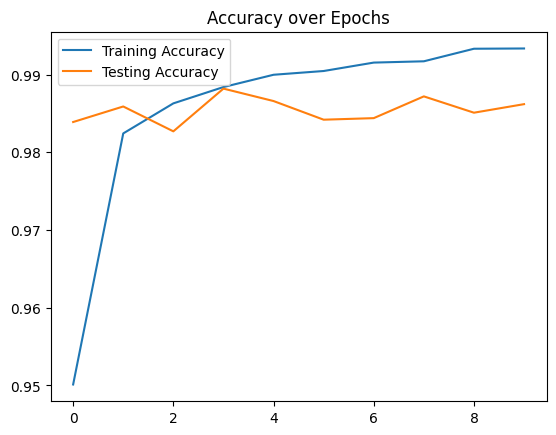

In [18]:
## Accuracy
plt.plot(train_accuracy,label="Training Accuracy")
plt.plot(test_accuracy,label="Testing Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.savefig("Accuracy")

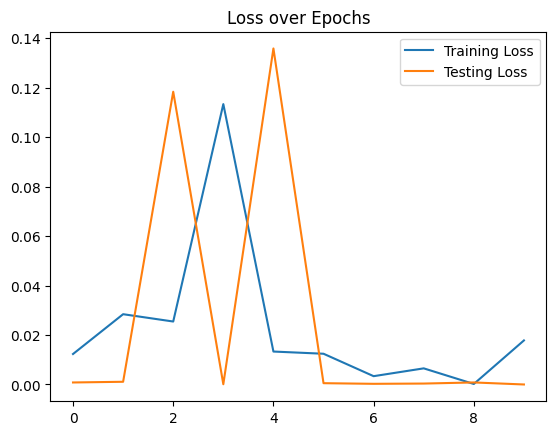

In [19]:
## Loss
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Testing Loss")
plt.legend()
plt.title("Loss over Epochs")
plt.savefig("Loss")

## Model Summary

In [20]:
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         MaxPool2d-2           [-1, 32, 13, 13]               0
            Conv2d-3           [-1, 64, 11, 11]          18,496
         MaxPool2d-4             [-1, 64, 5, 5]               0
            Linear-5                  [-1, 128]         204,928
            Linear-6                   [-1, 10]           1,290
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.28
Params size (MB): 0.86
Estimated Total Size (MB): 1.14
----------------------------------------------------------------


In [21]:
x=test_data[0][0].reshape(1,1,28,28)
y=model(x)

make_dot(y.mean(), params=dict(model.named_parameters())).render("Custom CNN Model", format="png")


'Custom CNN Model.png'

In [22]:

dummy_input = torch.randn(1, 1, 28, 28)
torch.onnx.export(model, dummy_input, "model.onnx")

In [23]:
parameters=model.named_parameters()

In [24]:
for name, param in parameters:
  print(name,param.size())

conv1.weight torch.Size([32, 1, 3, 3])
conv1.bias torch.Size([32])
conv2.weight torch.Size([64, 32, 3, 3])
conv2.bias torch.Size([64])
fc1.weight torch.Size([128, 1600])
fc1.bias torch.Size([128])
fc2.weight torch.Size([10, 128])
fc2.bias torch.Size([10])


In [25]:
train_accuracy

[0.9501166666666667,
 0.9824333333333334,
 0.9863,
 0.9884,
 0.9899833333333333,
 0.9904666666666667,
 0.99155,
 0.9917166666666667,
 0.9933333333333333,
 0.9933666666666666]

In [26]:
test_accuracy

[0.9839,
 0.9859,
 0.9827,
 0.9882,
 0.9866,
 0.9842,
 0.9844,
 0.9872,
 0.9851,
 0.9862]